In [1]:
import pandas as pd
import numpy as np
import requests
import json
import tweepy
import os
import re
import matplotlib.pyplot as plt

%matplotlib inline

# **Gathering Data**

### **Data provided from project resources**

In [2]:
twitarch_df = pd.read_csv('twitter-archive-enhanced-2.csv')

### **Data extracted through twitter API using tweepy**

In [3]:
consumer_key = os.environ.get("CONSUMER_KEY")
consumer_secret = os.environ.get("CONSUMER_SECRET")

auth = tweepy.AppAuthHandler(consumer_key, consumer_secret) # using OAuth 2
# https://knowledge.udacity.com/questions/66949#66975
api = tweepy.API(auth_handler = auth,
                 parser = tweepy.parsers.JSONParser(),
                 wait_on_rate_limit = True,
                 wait_on_rate_limit_notify = True)

##### Note: since it's time-consuming, code below ran only once successfully.
```python
twitid_lst = twitarch_df.tweet_id.values
with open ('tweet_json.txt', 'w') as ok, open('no_info.txt', 'w') as err:
    for id in twitid_lst:
        try:
            twit = api.get_status(id, tweet_mode='extended')
            ok.write(json.dumps(twit) + '\n')
        except Exception as e:
            # write the ids with no info to a file
            err.write(f"no info for {str(id)} with error: {str(e)}\n")
```

```
Rate limit reached. Sleeping for: 607
Rate limit reached. Sleeping for: 606
```

#### Note: the code above ran for 32 minutes. I started execution at 14:30 on 2020-08-24 (Aug 24 2020). It finished around 15:02.

In [4]:
# get the info from json object that will be merged with original df
added_features = []
with open('tweet_json.txt', 'r') as file:
    for item in file:
        data = json.loads(item)
        added_features.append({'tweet_id': data['id'],
                               'favorite_count': data['favorite_count'],
                               'retweet_count': data['retweet_count']})
added_fields = pd.DataFrame(added_features)

### **Data extracted using the `requests` library**

### The project details gave 2 different URLs for the image predictions data. I will compare the 2 below.

In [5]:
# retrieve data from url provided by the project
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
res = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(res.content)

In [6]:
# retrieve data from second URL indicated in the project
url_2 = 'https://video.udacity-data.com/topher/2018/November/5bf60c69_image-predictions-3/image-predictions-3.tsv'
res_2 = requests.get(url_2)
with open('image_predictions_2.tsv', 'wb') as file:
    file.write(res_2.content)

In [7]:
# project gave us 2 different links. They are identical
!diff -s image_predictions.tsv image_predictions_2.tsv

Files image_predictions.tsv and image_predictions_2.tsv are identical


### Since the 2 image_predictions files are identical, I will use the file extracted from first URL.

In [8]:
imagepred_df = pd.read_csv('image_predictions.tsv', sep='\t')

-----------------------

# **Assessing Data**

## Visual Assessment (using libreoffice and emacs)
twitter-archive-enhanced-2.csv
- this file has 2357 rows including the row of column names
- this file has many blank cells, esp `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`
- `retweeted_status_id`, `retweeted_status_user_id` interpreted by libreoffice as floats
- `None` is in many cells in columns `doggo`, `floofer`, `pupper`, `puppo`
- some rows under column `text` contains the string "doggo" or "pupper", but `doggo` and `pupper` columns had `None`
- the dog stage column names `doggo`, `floofer`, `pupper`, `puppo` are values of dog stages (according to project details).
- since many cells in `rating_denominator` are 10, the rating is mostly likely based out of 10
- but there are some cells in `rating_denominator` that do NOT have 10
- there are some cells in `rating_numerator` that more than 10
- some cells in `name` have ordinary English words like "a" and some have what seem like "real" names
- the "real" names in `name` seem to be capitalized

image_predictions.tsv
- this file has fewer rows than twitter-archive-enhanced-2.csv
- some names are not capitalized in columns `p1`, `p2`, `p3`
- some column names are not sufficiently descriptive like `p1`, `p2`, `p3`

tweet_json.txt
- it is very hard to read with a text editor but it has 2331 lines
- this file has fewer rows than twitter-archive-enhanced-2.csv

## Programmatic Assessment

### `twitarch_df` table

In [9]:
twitarch_df.info()
twitarch_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
twitarch_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
print(f"twitter archive: {twitarch_df.shape[0]} entries, {twitarch_df.tweet_id.nunique()} unique tweet_ids")

twitter archive: 2356 entries, 2356 unique tweet_ids


In [12]:
# Does text contain information about dog stages while the dog stage columns have `None`
twitarch_df[twitarch_df['text'].str.contains('doggo|pupper|puppo|floofer') &
            (twitarch_df['doggo'] == 'None') & (twitarch_df['floofer'] == 'None') &
            (twitarch_df['pupper'] == 'None') & (twitarch_df['puppo'] == 'None')].count()[0]

41

In [13]:
# What are the values and the counts in the dog stage columns
print(twitarch_df.doggo.value_counts())
print(twitarch_df.floofer.value_counts())
print(twitarch_df.pupper.value_counts())
print(twitarch_df.puppo.value_counts())

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


In [14]:
twitarch_df.name.nunique()

957

In [15]:
dog_name_df = twitarch_df.name.value_counts().to_frame()

In [16]:
dog_name_df.head()

,name
None,745
a,55
Charlie,12
Cooper,11
Oliver,11


The English word "a" is the most common name just after "None"

In [17]:
dog_name_df.sort_index(axis=0, inplace=True) # sorting by index which happens to be the names of dogs alphabetically

In [18]:
dog_name_df.head() # sorted alphabetically

,name
Abby,2
Ace,1
Acro,1
Adele,1
Aiden,1


In [19]:
# the top names above are capitalized and the bottom 30 have a mixed of capitalized names then followed by lower-cased English words
dog_name_df.tail(30).index

Index(['Ziva', 'Zoe', 'Zoey', 'Zooey', 'Zuzu', 'a', 'actually', 'all', 'an',
       'by', 'getting', 'his', 'incredibly', 'infuriating', 'just', 'life',
       'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite',
       'space', 'such', 'the', 'this', 'unacceptable', 'very'],
      dtype='object')

In [20]:
# according to project details "no retweets" for original ratings. This many will be dropped eventually
twitarch_df[twitarch_df.retweeted_status_id.notnull()].count()[0]

181

In [21]:
# to be used later for dropping
retweets_idx = twitarch_df[twitarch_df.retweeted_status_id.notnull()].index

In [22]:
twitarch_df['rating_denominator'][twitarch_df.rating_denominator != 10].count()

23

### `added_fields` table from JSON file

In [23]:
added_fields.info()
added_fields.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   favorite_count  2331 non-null   int64
 2   retweet_count   2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


,tweet_id,favorite_count,retweet_count
0,892420643555336193,35783,7568
1,892177421306343426,30896,5607
2,891815181378084864,23249,3714
3,891689557279858688,39055,7746
4,891327558926688256,37301,8346


In [24]:
added_fields.describe()

,tweet_id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7470.707422,2660.873016
std,6.823170e+16,11599.298490,4499.710811
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1300.000000,539.000000
50%,7.182469e+17,3247.000000,1244.000000
75%,7.986692e+17,9147.000000,3093.000000
max,8.924206e+17,154165.000000,76473.000000


In [25]:
print(f"from twitter API: {added_fields.shape[0]} entries, {added_fields.tweet_id.nunique()} unique tweet_ids")

from twitter API: 2331 entries, 2331 unique tweet_ids


### `imagepred_df` table

In [26]:
imagepred_df.info()
imagepred_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [27]:
imagepred_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [28]:
print(f"image prediction file: {imagepred_df.shape[0]} entries, {imagepred_df.tweet_id.nunique()} unique tweet_ids")

image prediction file: 2075 entries, 2075 unique tweet_ids


In [29]:
# are there p1_dog that is False but p2_dog or p3_dog are True
imagepred_df[(imagepred_df['p1_dog'] == False) & (imagepred_df.p2_dog | imagepred_df.p3_dog)].count()[0]

219

#### **Quality**

##### `twitarch_df` table from file `twitter-archive-enhanced-2.csv`
- the columns `doggo`, `floofer`, `pupper`, `puppo` are mostly the string "None".
- some rows under column `text` contain string "doggo" or "pupper", but `doggo` and `pupper` columns had `None`
- the `name` column has normal English words like "a", "the", "this"
- the "real" dog names are capitalized, the rest are in lower case
- `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` are mostly `NaN`
- both the `rating_numerator` and `rating_denominator` have some outliers, 1776 and 170 respectively
- `expanded_urls` has missing data
- there are retweets mixed in data. According to project details, they are not used

##### `added_fields` table from file `tweet_json.txt`
- table has 2331 entries. It has fewer entries than the table `twitarch_df`
- some `favorite_count` has 0 entries.

##### `imagepred_df` table from file `image_predictions.tsv`
- table has 2075 entries. It has fewer entries than the table `twitarch_df`
- there are capitalization issues in entries under `p1`, `p2`, `p3`
- there are high confidence numbers for `p1` but has `False` under `p1_dog`.
- but has `True` in `p2_dog` or `p3_dog`

#### **Tidiness**

##### `twitarch_df` table
- the columns `doggo`, `floofer`, `pupper`, `puppo` are dog stage values
- `timestamp` and `retweeted_status_timestamp` are not datetime type
- `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` are type `float64`, and not `int64`

##### `added_fields` table
- no structural issues found

##### `imagepred_df` table
- many column names like `p1`, `p2`, `p3` are not descriptive
- `p1`, `p1_conf`, `p1_dog`, `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`, `p3_dog` have extraneous information. The information can be combined into 2 variables

### **Since these are related tables, they should all be merged ultimately.**

--------------------------------
# **Cleaning Data**

In [30]:
# make copies
twitarch_work = twitarch_df.copy()
imagepred_work = imagepred_df.copy()
addedfields_work = added_fields.copy()

**Define**: combine the columns `doggo`, `floofer`, `pupper`, `puppo` into one called `dog_stage`

**Code**

In [31]:
dog_stage = ['doggo', 'floofer', 'pupper', 'puppo']

In [32]:
# replacing the string "None" to null, so I can manipulate the columns better
for ds in dog_stage:
    twitarch_work[ds].replace({'None': np.nan}, inplace=True)

In [33]:
# create a new column that sums by row the dog_stages
twitarch_work['ds_sum'] = twitarch_work[dog_stage].notnull().sum(axis=1)

In [34]:
twitarch_work[dog_stage + ['ds_sum']].loc[9:13] # sample view of ds_sum

,doggo,floofer,pupper,puppo,ds_sum
9,doggo,NaN,NaN,NaN,1
10,NaN,NaN,NaN,NaN,0
11,NaN,NaN,NaN,NaN,0
12,NaN,NaN,NaN,puppo,1
13,NaN,NaN,NaN,NaN,0


In [35]:
# get all the indices of specific dog stages, then write into cell the dog stage in new column dog_stage
for ds in dog_stage:
    tidx = twitarch_work[(twitarch_work.text.str.contains(ds, case=False)) & (twitarch_work['ds_sum'] == 0)].index
    # for all the indices found for that dog stage, write the dog stage
    twitarch_work.loc[tidx, ds] = ds

In [36]:
# do the same as creation of the column ds_sum above but this time accounting for the recent additions just above
twitarch_work['ds_sum'] = twitarch_work[dog_stage].notnull().sum(axis=1) # sum the 4 dog_stage

In [37]:
# verify that text containing a dog stage are accounted for
twitarch_work[(twitarch_work.text.str.contains('doggo|pupper|puppo|floofer', case=False)) & (twitarch_work['ds_sum'] == 0)].count()[0]

0

In [38]:
# casting was more complicated than usual.
# adding the contents of from each column and into dog_stage
twitarch_work['dog_stage'] = twitarch_work.doggo.fillna('').map(str) + twitarch_work.floofer.fillna('').map(str) + \
                                twitarch_work.pupper.fillna('').map(str) + twitarch_work.puppo.fillna('').map(str)

# prefix the multiple dog stages with "combo"
combo_idx = twitarch_work[twitarch_work.ds_sum > 1].index
twitarch_work.loc[combo_idx, 'dog_stage'] = 'combo-' + twitarch_work['dog_stage']

# for completeness, replacing all empty strings to string "None"
twitarch_work['dog_stage'].replace({'': 'None'}, inplace=True)

**Test**

In [39]:
twitarch_work.dog_stage.value_counts()

None                  1933
pupper                 271
doggo                   93
puppo                   36
combo-doggopupper       12
floofer                  9
combo-doggofloofer       1
combo-doggopuppo         1
Name: dog_stage, dtype: int64

---------------------------------------------------
**Define**: change non-"real" dog names to "None"

**Code**

In [40]:
# replace all the non-capitalized English words with string "None"
twitarch_work['name'].replace(to_replace=r'^[a-z]+', value='None', regex=True, inplace=True)

**Test**

In [41]:
check_df = twitarch_work['name'].value_counts().to_frame()

In [42]:
check_df.sort_index(axis=0, inplace=True) # sort alphabetically
check_df

,name
Abby,2
Ace,1
Acro,1
Adele,1
Aiden,1
...,...
Ziva,1
Zoe,1
Zoey,3
Zooey,1


-----------------------------------
**Define**: add missing data in `expanded_urls`.
Note: an expanded url takes the form: https://twitter.com/dog_rates/status/{tweet_id}

**Code**

In [43]:
# created a new column that is a string copy of the tweet_id in order to quickly concatenate string url and tweet_id
twitarch_work['tweet_id_str'] = twitarch_work.tweet_id.astype('str')
twitarch_work.expanded_urls.fillna('https://twitter.com/dog_rates/status/' + twitarch_work['tweet_id_str'], inplace=True)

**Test**

In [44]:
twitarch_work.expanded_urls.isnull().sum()

0

--------------------------------------------
**Define**: fix `rating_denominator` that is not 10, then fix `rating_numerator` accordingly

**Code**

In [45]:
not_10_idx = twitarch_work[twitarch_work.rating_denominator != 10].index

In [46]:
# first find in text of any possible rating, then extract.
# if the 2 regular expression patterns below are not found, then imputing median numerator and 10 denominator
pat = re.compile('(\d+)\/10') # pattern of ##/10
pat2 = re.compile('(\d+)\/(\d+)\D+\D') # pattern of anynumber/anynumber

In [47]:
median = twitarch_work.rating_numerator.median()
for idx in not_10_idx:
    string = twitarch_work.loc[idx, 'text']
    rate = pat.search(string)
    rate2 = pat2.search(string)
    if rate:
        numerator = rate.groups()[0]
    elif rate2:
        numerator = int(rate2.groups()[0]) * 10 / int(rate2.groups()[1])
    else:
        numerator = median

    twitarch_work.loc[idx, 'rating_numerator'] = int(numerator)
    twitarch_work.loc[idx, 'rating_denominator'] = 10

**Test**

In [48]:
twitarch_work[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.0
mean,12.235144,10.0
std,40.824932,0.0
min,0.000000,10.0
25%,10.000000,10.0
50%,11.000000,10.0
75%,12.000000,10.0
max,1776.000000,10.0


Note: The outlier 1776 is still there in rating_numerator but it had 10 as denominator. All `rating_denominator` are 10.

-------------------------------------------------
**Define**: change the data type for all timestamps to `datetime64[ns]` and change all IDs from `float64` to `int64`

**Code**

In [49]:
# source: https://www.geeksforgeeks.org/convert-the-column-type-from-string-to-datetime-format-in-pandas-dataframe/
twitarch_work['timestamp'] = twitarch_work.timestamp.astype('datetime64[ns]')
twitarch_work['retweeted_status_timestamp'] = twitarch_work.retweeted_status_timestamp.astype('datetime64[ns]')

In [50]:
irr_lst = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id']
for col in irr_lst:
    twitarch_work[col].fillna(0, inplace=True) # needed to impute zero in order for casting to work
    twitarch_work[col] = twitarch_work[col].astype('int64')

**Test**

In [51]:
twitarch_work[['timestamp', 'retweeted_status_timestamp'] + irr_lst].dtypes

timestamp                     datetime64[ns]
retweeted_status_timestamp    datetime64[ns]
in_reply_to_status_id                  int64
in_reply_to_user_id                    int64
retweeted_status_id                    int64
retweeted_status_user_id               int64
dtype: object

In [52]:
# check if any information is lost upon casting from float64 to int64
twitarch_work.loc[107:113, irr_lst]

,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id
107,0,0,0,0
108,0,0,0,0
109,0,0,841077006473256960,4196983835
110,0,0,0,0
111,0,0,0,0
112,0,0,0,0
113,870726202742493184,16487760,0,0


**Note**: I was concerned that by casting to int64, I would lose information... apparently not

-------------------------------------------
**Define**: merge `added_fields_work` table based on JSON file

**Code**

In [53]:
work_df = pd.merge(twitarch_work, addedfields_work, on=['tweet_id'], how='left')

**Test**

In [54]:
work_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'ds_sum', 'dog_stage', 'tweet_id_str', 'favorite_count',
       'retweet_count'],
      dtype='object')

----------------------------------
**Define**: impute zeroes into `NaN` cells under `favorite_count` and `retweet_count`

**Code**

In [55]:
work_df.favorite_count.fillna(0, inplace=True)
work_df.retweet_count.fillna(0, inplace=True)

**Test**

In [56]:
work_df[['favorite_count', 'retweet_count']].isnull().sum()

favorite_count    0
retweet_count     0
dtype: int64

----------------------------------
**Define**: merge `imagepred_work` table to `work_df`

**Code**

In [57]:
pred_df = pd.merge(work_df, imagepred_work, on=['tweet_id'], how='left')

**Test**

In [58]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       2356 non-null   int64         
 2   in_reply_to_user_id         2356 non-null   int64         
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         2356 non-null   int64         
 7   retweeted_status_user_id    2356 non-null   int64         
 8   retweeted_status_timestamp  181 non-null    datetime64[ns]
 9   expanded_urls               2356 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

**Note**: The `bool` dtype of columns `p1_dog`, `p2_dog`, `p3_dog` converted to object and `img_num` to `float64`. It will be addressed eventually below.

-------------------------------------
**Define**: fill `NaN` with default values for completeness

**Code**

In [59]:
pred_cols = imagepred_work.columns.tolist() # put column names from imagepred_work to list

In [60]:
# to be used in for loop for filling in values in fillna()
na_dict = dict(zip(pred_cols[1:], ['None', 0, 'None', 0.0, False, 'None', 0.0, False, 'None', 0.0, False]))

In [61]:
# declaratively replace all the nulls in colums specified in na_dict with the values
for key, val in na_dict.items():
    pred_df[key].fillna(val, inplace=True)

**Test**

In [62]:
pred_df[pred_cols[1:]].isnull().sum()

jpg_url    0
img_num    0
p1         0
p1_conf    0
p1_dog     0
p2         0
p2_conf    0
p2_dog     0
p3         0
p3_conf    0
p3_dog     0
dtype: int64

---------------------------------------
**Define**: as noted above, the `bool` data type for `p1_dog`, `p2_dog`, `p3_dog` casted to `object` upon merging since there were unmatched `tweet_id`s.
`p1_dog`, `p2_dog`, `p3_dog` will be converted to `bool`. `img_num` to `int64`

**Code**

In [63]:
pred_df['p1_dog'] = pred_df.p1_dog.astype('bool')
pred_df['p2_dog'] = pred_df.p2_dog.astype('bool')
pred_df['p3_dog'] = pred_df.p3_dog.astype('bool')
pred_df['img_num'] = pred_df.img_num.astype('int64')

**Test**

In [64]:
print(f"img_num: {pred_df.img_num.dtypes}, p1_dog: {pred_df.p1_dog.dtypes}, p2_dog: {pred_df.p2_dog.dtypes}, p3_dog: {pred_df.p3_dog.dtypes}")

img_num: int64, p1_dog: bool, p2_dog: bool, p3_dog: bool


-----------------------------------
**Define**: fix the capitalization issue in `p1`, `p2`, `p3`

**Code**

In [65]:
# consistency in capitalization
pred_df['p1'] = pred_df['p1'].str.lower()
pred_df['p2'] = pred_df['p2'].str.lower()
pred_df['p3'] = pred_df['p3'].str.lower()

**Test**

In [66]:
pred_df.loc[:, ['p1', 'p2', 'p3']]

,p1,p2,p3
0,orange,bagel,banana
1,chihuahua,pekinese,papillon
2,chihuahua,malamute,kelpie
3,paper_towel,labrador_retriever,spatula
4,basset,english_springer,german_short-haired_pointer
...,...,...,...
2351,miniature_pinscher,rottweiler,doberman
2352,rhodesian_ridgeback,redbone,miniature_pinscher
2353,german_shepherd,malinois,bloodhound
2354,redbone,miniature_pinscher,rhodesian_ridgeback


--------------------------------------
**Define**: combine info from prediction columns into 2 variables `dog_breed_prediction` and `dog_breed_confidence`

**Code**

In [67]:
# Steps:
# 1) if p1_dog is True and dog_breed_prediction is null, then put p1 as dog_breed_prediction and put p1_conf in dog_breed_confidence
# 2) if p2_dog is True, then put p2 in dog_breed accordingly
# 3) if p3_dog is True, put p3 in dog_breed accordingly
# 4) for completeness, fill nulls in dog_breed_prediction with "None"

# Initialize the new columns
pred_df['dog_breed_prediction'] = np.nan
pred_df['dog_breed_confidence'] = 0

In [68]:
# find all the indices where p1_dog is True if dog_breed_prediction still NaN
p1_idx = pred_df[pred_df.dog_breed_prediction.isnull() & pred_df.p1_dog].index
pred_df.loc[p1_idx, 'dog_breed_prediction'] = pred_df['p1']
pred_df.loc[p1_idx, 'dog_breed_confidence'] = pred_df['p1_conf']

In [69]:
# find all the indices where p2_dog is True if dog_breed_prediction still NaN
p2_idx = pred_df[pred_df.dog_breed_prediction.isnull() & pred_df.p2_dog].index
pred_df.loc[p2_idx, 'dog_breed_prediction'] = pred_df['p2']
pred_df.loc[p2_idx, 'dog_breed_confidence'] = pred_df['p2_conf']

In [70]:
# find all the indices where p3_dog is True if dog_breed_prediction still NaN
p3_idx = pred_df[pred_df.dog_breed_prediction.isnull() & pred_df.p3_dog].index
pred_df.loc[p3_idx, 'dog_breed_prediction'] = pred_df['p3']
pred_df.loc[p3_idx, 'dog_breed_confidence'] = pred_df['p3_conf']

In [71]:
pred_df.dog_breed_prediction.fillna('None', inplace=True)

**Test**

In [72]:
pred_df[['tweet_id'] + pred_cols[3:] + ['dog_breed_prediction', 'dog_breed_confidence']]

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed_prediction,dog_breed_confidence
0,892420643555336193,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None,0.000000
1,892177421306343426,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,chihuahua,0.323581
2,891815181378084864,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,chihuahua,0.716012
3,891689557279858688,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,labrador_retriever,0.168086
4,891327558926688256,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,basset,0.555712
...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,miniature_pinscher,0.560311
2352,666044226329800704,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,rhodesian_ridgeback,0.408143
2353,666033412701032449,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,german_shepherd,0.596461
2354,666029285002620928,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True,redbone,0.506826


--------------------------
**Define**: delete the rows that have content in column `retweeted_status_id`. These are considered "retweets" which are to be excluded.

**Code**

In [73]:
pred_df.drop(retweets_idx, axis=0, inplace=True) # indices of retweets extracted earlier

**Test**

In [74]:
pred_df[pred_df.retweeted_status_id != 0].count()['tweet_id']

0

-----------------------------------
**Define**: drop helper columns like `ds_sum`, unnecessary columns like `retweeted_status_id`, redundant columns like `p1`, `p1_dog`, `p1_conf`

**Code**

In [75]:
final_df = pred_df.copy()

In [76]:
drop_columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
             'retweeted_status_timestamp', 'doggo', 'floofer', 'pupper', 'puppo', 'ds_sum', 'tweet_id_str', 
             'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']

In [77]:
final_df.drop(drop_columns,axis=1, inplace=True)

In [78]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tweet_id              2175 non-null   int64         
 1   timestamp             2175 non-null   datetime64[ns]
 2   source                2175 non-null   object        
 3   text                  2175 non-null   object        
 4   expanded_urls         2175 non-null   object        
 5   rating_numerator      2175 non-null   int64         
 6   rating_denominator    2175 non-null   int64         
 7   name                  2175 non-null   object        
 8   dog_stage             2175 non-null   object        
 9   favorite_count        2175 non-null   float64       
 10  retweet_count         2175 non-null   float64       
 11  jpg_url               2175 non-null   object        
 12  img_num               2175 non-null   int64         
 13  dog_breed_predicti

In [79]:
final_df.to_csv('twitter_archive_master.csv', index=False)

**Test**

In [80]:
final_df = pd.read_csv('twitter_archive_master.csv', parse_dates=['timestamp'])

In [81]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tweet_id              2175 non-null   int64         
 1   timestamp             2175 non-null   datetime64[ns]
 2   source                2175 non-null   object        
 3   text                  2175 non-null   object        
 4   expanded_urls         2175 non-null   object        
 5   rating_numerator      2175 non-null   int64         
 6   rating_denominator    2175 non-null   int64         
 7   name                  2175 non-null   object        
 8   dog_stage             2175 non-null   object        
 9   favorite_count        2175 non-null   float64       
 10  retweet_count         2175 non-null   float64       
 11  jpg_url               2175 non-null   object        
 12  img_num               2175 non-null   int64         
 13  dog_breed_predicti

In [82]:
final_df

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,jpg_url,img_num,dog_breed_prediction,dog_breed_confidence
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,35783.0,7568.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,None,0.000000
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,30896.0,5607.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,23249.0,3714.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,39055.0,7746.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,37301.0,8346.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,666049248165822465,2015-11-16 00:24:50,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,96.0,40.0,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311
2171,666044226329800704,2015-11-16 00:04:52,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,None,None,266.0,129.0,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143
2172,666033412701032449,2015-11-15 23:21:54,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,None,None,111.0,41.0,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461
2173,666029285002620928,2015-11-15 23:05:30,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,None,None,120.0,42.0,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826


-----------------------
# **Analyses**

In [83]:
final_df.describe()

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,dog_breed_confidence
count,2.175000e+03,2175.000000,2175.0,2175.000000,2175.000000,2175.000000,2175.000000
mean,7.371205e+17,12.247356,10.0,8006.537471,2401.287356,1.102989,0.426295
std,6.748668e+16,42.466313,0.0,11828.190067,4281.205119,0.631484,0.349498
min,6.660209e+17,0.000000,10.0,0.000000,0.000000,0.000000,0.000000
25%,6.768432e+17,10.000000,10.0,1685.000000,516.000000,1.000000,0.033697
50%,7.098528e+17,11.000000,10.0,3606.000000,1143.000000,1.000000,0.406509
75%,7.894226e+17,12.000000,10.0,9929.000000,2721.500000,1.000000,0.749136
max,8.924206e+17,1776.000000,10.0,154165.000000,76473.000000,4.000000,0.999956


In [84]:
final_df.corr()

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,dog_breed_confidence
tweet_id,1.000000,0.049523,NaN,0.584286,0.360422,0.140386,0.108018
rating_numerator,0.049523,1.000000,NaN,0.014479,0.015269,-0.022185,-0.034274
rating_denominator,NaN,NaN,NaN,NaN,NaN,NaN,NaN
favorite_count,0.584286,0.014479,NaN,1.000000,0.926839,0.128061,0.077764
retweet_count,0.360422,0.015269,NaN,0.926839,1.000000,0.088117,0.026103
img_num,0.140386,-0.022185,NaN,0.128061,0.088117,1.000000,0.304077
dog_breed_confidence,0.108018,-0.034274,NaN,0.077764,0.026103,0.304077,1.000000


There is a high correlation between favorite_count and retweet_count.

There is somewhat a correlation between dog_breed_confidence and the number of pictures. I am imagining that the more pictures there are the slightly likelier that confidence of prediction is higher.

I expected to have some correlation between rating numerator and the favorite or retweet counts.

In [106]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = final_df['retweet_count'].to_numpy()
y = final_df['favorite_count'].to_numpy()
model.fit(X.reshape(-1,1), y)

LinearRegression()

In [107]:
X_line = np.linspace(min(X),max(X),2) # why 100 points
y_line = model.coef_ * X_line + model.intercept_

Text(0, 0.5, 'favorite_count')

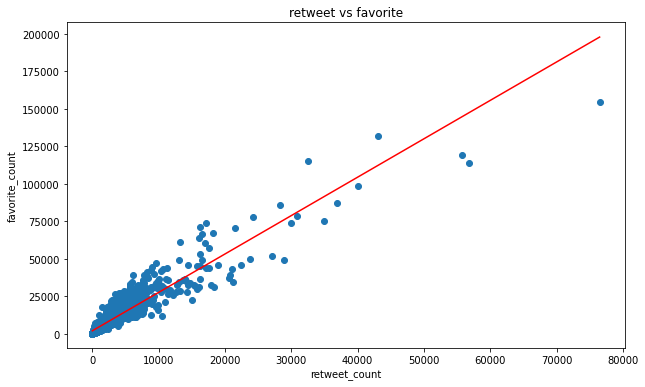

In [109]:
plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X_line, y_line, color='r')
plt.title('retweet vs favorite')
plt.xlabel('retweet_count')
plt.ylabel('favorite_count')

In [120]:
# exclude "none"
ds = final_df['dog_stage'].value_counts()
ds_counts = ds.to_list()[1:]
dog_stage = ds.index.to_list()[1:]

I only need to use the linear regression in order to get the slope and intercept to show a line that shows a correlation betweet the counts.

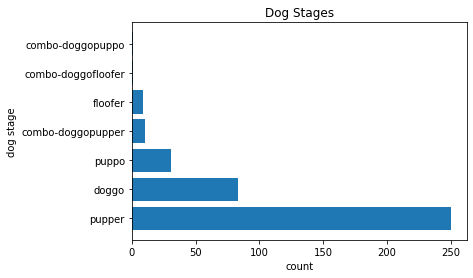

In [125]:
plt.barh(dog_stage, ds_counts)
plt.title('Dog Stages')
plt.xlabel('count')
plt.ylabel('dog stage');

In [127]:
dbp = final_df['dog_breed_prediction'].value_counts()
db_counts = dbp.to_list()[1:20]
dog_breed = dbp.index.to_list()[1:20]

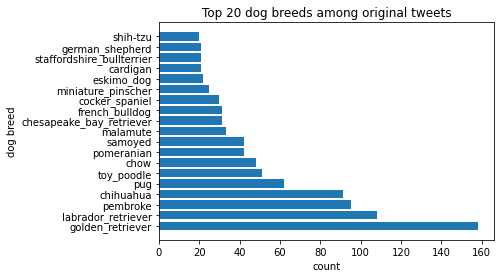

In [146]:
plt.barh(dog_breed, db_counts)
plt.title('Top 20 dog breeds among original tweets')
plt.xlabel('count')
plt.ylabel('dog breed');

Among the original tweets, these are the 20 dog breeds

In [132]:
#final_df.loc[final_df['dog_breed_prediction'] == 'golden_retriever', 'retweet_count'].sum()

513348.0

In [155]:
dog_breed_by_rt_count = final_df.groupby('dog_breed_prediction')['retweet_count'].sum()

In [156]:
dbrt_ct = dog_breed_by_rt_count.to_list()[1:20]
dog_breed_rt = dog_breed_by_rt_count.index.to_list()[1:20]

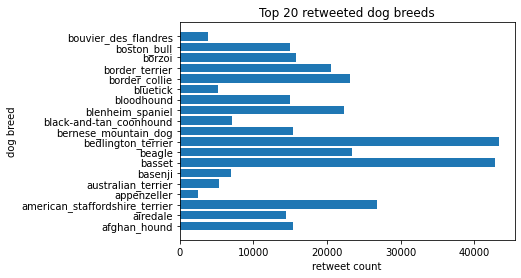

In [157]:
plt.barh(dog_breed_rt, dbrt_ct)
plt.title('Top 20 retweeted dog breeds')
plt.xlabel('retweet count')
plt.ylabel('dog breed');

In [149]:
dbrt_df = dog_breed_by_rt_count.to_frame()
dbrt_df.reset_index()
#dbrt_df.sort_values('retweet_count', ascending=False)[1:20]

,dog_breed_prediction,retweet_count
0,None,1093163.0
1,afghan_hound,15411.0
2,airedale,14458.0
3,american_staffordshire_terrier,26722.0
4,appenzeller,2489.0
...,...,...
109,welsh_springer_spaniel,3791.0
110,west_highland_white_terrier,20457.0
111,whippet,48612.0
112,wire-haired_fox_terrier,5115.0


In [154]:
dbrt_t = dbrt_df.sort_values('retweet_count', ascending=False)
dbrt_counts = dbrt_t.to_list()[1:20]
dog_breed = dbrt_t.index.to_list()[1:20]

AttributeError: 'DataFrame' object has no attribute 'to_list'

In [152]:
dog_breed_by_fav_count = final_df.groupby('dog_breed_prediction')['favorite_count'].sum()

In [145]:
dbfav_df = dog_breed_by_fav_count.to_frame()
dbfav_df.sort_values('favorite_count', ascending=False)[1:20]

,favorite_count
dog_breed_prediction,
golden_retriever,1785537.0
labrador_retriever,1117288.0
pembroke,958952.0
chihuahua,711337.0
french_bulldog,556617.0
samoyed,510312.0
chow,413221.0
cocker_spaniel,374226.0
pug,345525.0
